In [ ]:
pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 7.4 MB/s eta 0:00:00


In [ ]:
import pypdf
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from typing import List, Dict
import torch
from tqdm import tqdm

class PDFQAApp:
    def __init__(self, model_name: str = "deepset/roberta-large-squad2"):
        # Initialize QA pipeline
        self.qa_pipeline = pipeline(
            "question-answering",
            model=model_name,
            tokenizer=model_name,
            device=0 if torch.cuda.is_available() else -1
        )

        # Store document chunks
        self.chunks = []

    def extract_text_from_pdf(self, pdf_path: str) -> str:
        text = ""
        with open(pdf_path, 'rb') as file:
            reader = pypdf.PdfReader(file)
            for page in reader.pages:
                text += page.extract_text()
        return text

    def split_into_chunks(self, text: str, chunk_size: int = 500, overlap: int = 50) -> List[str]:
        words = text.split()
        chunks = []
        start_idx = 0

        while start_idx < len(words):
            end_idx = start_idx + chunk_size

            # Handle the last chunk
            if end_idx >= len(words):
                chunks.append(' '.join(words[start_idx:]))
                break

            # Find the last period in the chunk to break at a natural point
            chunk = ' '.join(words[start_idx:end_idx])
            last_period = chunk.rfind('.')

            if last_period != -1:
                end_idx = start_idx + chunk[:last_period].count(' ') + 1

            chunks.append(' '.join(words[start_idx:end_idx]))
            start_idx = end_idx - overlap

        return chunks

    def process_pdf(self, pdf_path: str) -> None:
        print("Extracting text from PDF...")
        text = self.extract_text_from_pdf(pdf_path)
        print("Splitting text into chunks...")
        self.chunks = self.split_into_chunks(text)
        print(f"Generated {len(self.chunks)} chunks.")

    def get_response(self, query: str, top_k: int = 10) -> str:
        if not self.chunks:
            return "No document has been processed yet."

        # Process each chunk with the QA model
        answers = []
        for chunk in tqdm(self.chunks, desc="Analyzing chunks"):
            try:
                result = self.qa_pipeline(
                    question=query,
                    context=chunk,
                    max_answer_length=100,
                    handle_impossible_answer=True
                )

                # Only keep answers with high confidence
                if result['score'] > 0.1: # Adjust threshold as needed
                    answers.append({
                        'answer': result['answer'],
                        'score': result['score'],
                        'context': chunk
                    })
            except Exception as e:
                print(f"Error processing chunk: {str(e)}")
                continue

        # Sort answers by confidence score
        answers.sort(key=lambda x: x['score'], reverse=True)

        # Prepare response
        if not answers:
            return "I couldn't find a confident answer to your question in the document."

        response = f"Here are the top {min(top_k, len(answers))} answers I found:\n\n"
        print("'''''''''''''''''''''''''''''''''''''''''''''''''''answers: ",answers)

        for i, answer in enumerate(answers[:top_k], 1):
            response += f"{i}. Answer: {answer['context'][:1500]}\n"
            response += f" Confidence: {answer['score']:.2%}\n\n"

        return response

class PDFQAFactory:
    @staticmethod
    def create_qa_app(model_type: str = "default"):
        model_mappings = {
            "default": "deepset/roberta-base-squad2",
            "multilingual": "deepset/xlm-roberta-large-squad2",
            "distilled": "distilbert-base-cased-distilled-squad",
            "large": "deepset/roberta-large-squad2"
        }

        model_name = model_mappings.get(model_type, model_mappings["large"])
        return PDFQAApp(model_name)




In [ ]:
def main():
    try:
        # Create QA app with chosen model
        app = PDFQAFactory.create_qa_app("default") # or "multilingual", "distilled", "large"

        # Process PDF
        pdf_path = "SolarSystem.pdf"
        app.process_pdf(pdf_path)

        # Chat loop
        while True:
            query = input("\nAsk a question (or type 'exit' to quit): ")
            if query.lower() == 'exit':
                break

            response = app.get_response(query)
            print("\nResponse:", response)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Extracting text from PDF...
Splitting text into chunks...
Generated 3 chunks.

Ask a question (or type 'exit' to quit): solar system


Analyzing chunks: 100%|██████████| 3/3 [00:18<00:00,  6.03s/it]


'''''''''''''''''''''''''''''''''''''''''''''''''''answers:  [{'answer': '', 'score': 0.9798634052276611, 'context': 'planets, Mercury, Venus, Earth, and Mars, are also called theterrestrial planetsbecauseof their rockycompositions. Theseplanetsaresmaller, have solid surfaces, and are composed primarily of silicate rocksand metals. They have relatively thin atmospheres compared to the gasgiantsintheoutersolarsystem. ● Mercury, theclosest planet totheSun, hasasurfaceheavilycrateredbyimpacts, anditsproximitytotheSungivesit extremetemperaturefluctuations, rangingfromextremelyhot duringthedaytofreezingat night.● Venus, Earth’s“sisterplanet,”issimilarinsizeandcompositionbuthasanextremelythickatmospheredominatedbycarbondioxide,causingarunawaygreenhouseeffect. Thisresultsinsurfacetemperaturesexceeding460°C(860°F), makingVenusthehottestplanet inthesolarsystem.TheOuterPlanets The outer planets, also known as gas giants (Jupiter and Saturn) andice giants (Uranus and Neptune), are massive compare

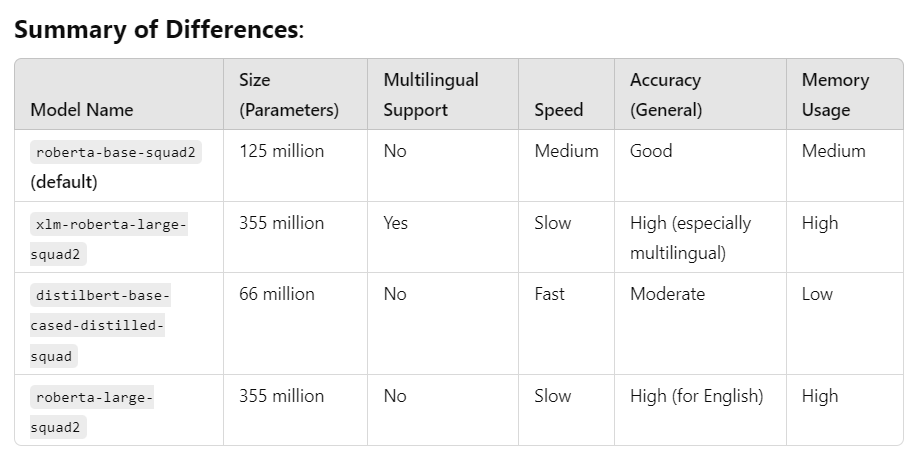